In [2]:
!pip install graphviz
!pip install pydotplus

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, List
import io
import pydotplus
from IPython.display import Image

RANDOM_SEED = 0xdeadbeef

# Task 1: Manual Calculation in Decision Trees (2 Points)

Decision Trees are a relatively simple and interpretable type of model that can be used both for classification and regression. In this lab we will look at how they are implemented for **classification**.

In their simplest form, a Decision Tree is a *Binary Tree* that splits the data
at each node into two parts, based on some criterion.

The following table shows data about a person’s past sailing plans, i.e., whether or not the person went out sailing, based on various external conditions — or “input features” — e.g., wind speed in knots, maximum temperature, outlook, and whether or not the boat was loaded (storage is full). 

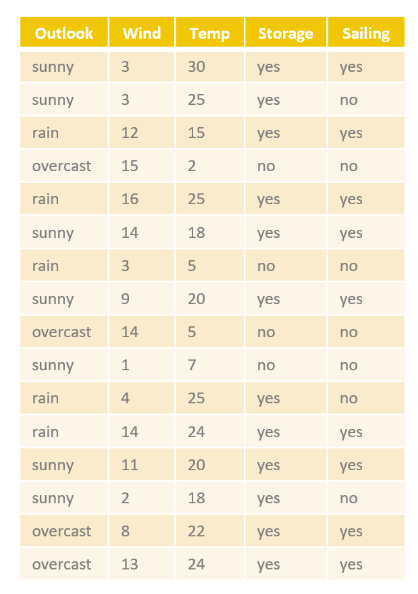

(source: https://www.knime.com/blog/from-a-single-decision-tree-to-a-random-forest)

Here is the decision tree that predicts whether the person goes for sailing: 

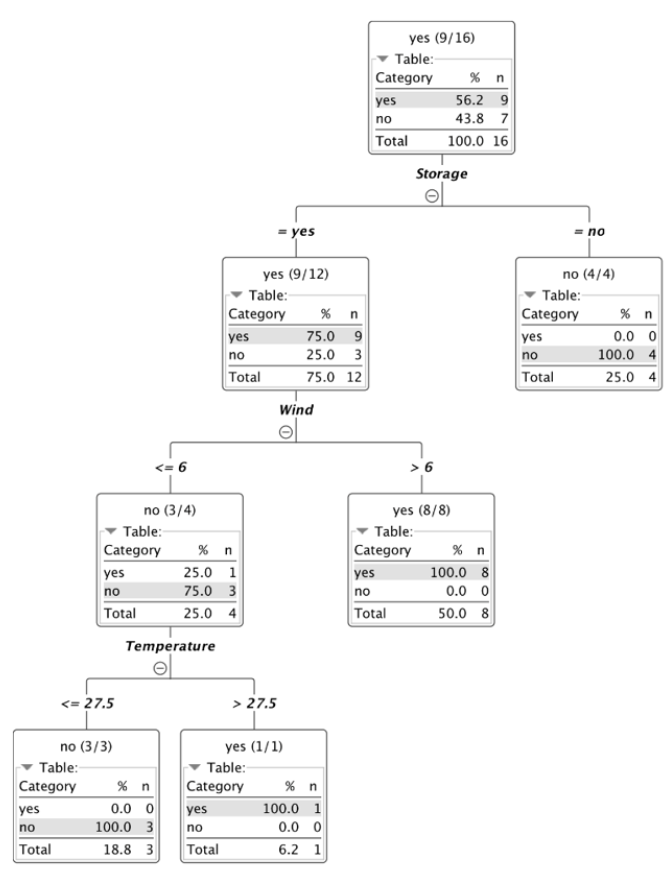

We will use this example as basis to calculate some properties of decision trees by hand, which will help to understand how they are built. 

### Task 1a. Prediction

Assume a nice summer day where the forecast is sunny, the wind speed is moderate at 5, the temperature is 30 degrees and the boat is, of course, loaded (storage is full). What would the decision tree predict?


In [4]:
#Watching the Decision Tree, we would end at the bottom left, in the right node which says yes

### Task 1b. Gini Impurity

In class you have seen the *Gini Impurity* as one possible criterion to split data points.

The Gini Impurity is computed on a collection of class labels. Assume we are given a list of $n$ class labels. Each label can have one of $k$ discrete values. Then the Gini Impurity is computed as: $\sum_{c = 1}^{k} p_c(1 - p_c)$. In this formula $p_c = \frac{n_c}{n}$ is the fraction of labels of class $c$.

In class you have seen a simplified version with only 2 classes: "Yes" (1) and "No" (0). In that case the Gini Impurity simplifies to: $1 - p_1^2 - p_0^2$.

Calculate Gini Impurity of the two nodes on the third level ("no = 3/4" and "yes=8/8")


In [5]:
"""
Wind <=6: 1- (1/4)2 - (3/4)2 = 0.375
Wind >6: 1- (8/8)2 - (0/8)2 = 0
Weighted average of Gini Impurities of the leaves
(4/12)*0.375 + (8/12)*0 = 0.125
"""

'\nWind <=6: 1- (1/4)2 - (3/4)2 = 0.375\nWind >6: 1- (8/8)2 - (0/8)2 = 0\nWeighted average of Gini Impurities of the leaves\n(4/12)*0.375 + (8/12)*0 = 0.125\n'

### Task 1c. Alternative Criterion
Assume that the tree was only computed until the second level (where currently the split is by "wind <= 6"). Compute the split that would occur if we would use two nodes "Temperature <= 18" and "Temperature > 18" instead. What is the Gini impurity of this split for the two nodes? Compare to task b)


In [6]:
"""
Because the temparature is in the third level now, it will have 12 Total.

<=18
yes | 28.5% | 2
no  | 71.5% | 5
tot  | 100%  | 7
1 - (2/7)^2 - (5/7)^2 = 0.408163

>18
yes | 77.8% | 7
no  | 22.2% | 2
tot  | 100%  | 9
1 - (7/9)^2 - (2/9)^2 = 0.345679

Gini Score
7/16 * 0.408163 + 9/16 *0 = 0.345679 = 0.373016

"""

'\nBecause the temparature is in the third level now, it will have 12 Total.\n\nNew Temp Node:\n<= 27.5 -> yes: 8, No: 3\n> 27.5 -> yes: 1 No: 0\n\nTemp <=27.5: 1- (8/11)^2 - (3/11)^2 = ~0.4\nTemp >27.5: 1- (1/1)^2 - (0/1)^2 = 0\nWeighted average of Gini Impurities of the leaves\n(11/12)*0.4 + (1/12)*0 = 0.367\n\n'

## 📢 **HAND-IN** 📢: Enter the following in **Moodle**

* Prediction from 1a
* Gini Impurities from 1b 
* Gini Impurities from 1c. 

# Task 2: Rotation of Decision Boundaries (3 points)

In this task you will use the default Decision Tree classifier from scikit learn and visualize its results. Then you will rotate the input data to see how the decision tree adapts to the new data. 

As always, we start out by creating some synthetic data. You should notice that this data is not linearly separable, meaning there is no line such that all red points are on one side and all the yellow points on the other.

One nice feature of Decision Trees is that they can handle situations like this without any "tricks".

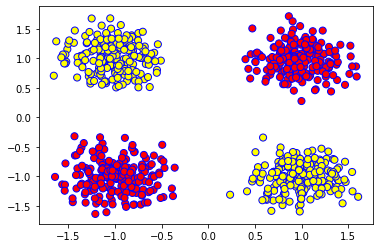

In [7]:
from sklearn.datasets import make_blobs

X, y = make_blobs(
    n_samples=800,
    n_features=2,
    centers=np.array([
        [-1., -1.],
        [1., -1],
        [1., 1.],
        [-1., 1.],
    ]),
    cluster_std=0.25,
    random_state=RANDOM_SEED,
)
y[y == 2] = 0
y[y == 3] = 1

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap="autumn", edgecolors='b')

### Trying it out

We now want to apply the Decision Tree implementation from scikit-learn to the data. For this, we provide the function `plot_decision_boundaries` in the next cell, which we will use to visualize the decision regions. 


In [8]:
# Helper function to visualize the decision boundaries and regions of a classifier
# You do not need to read it or understand how it works

def plot_decision_boundaries(
  classifier,
  data: np.array,
  labels: np.array,
):
  """
  Plot the decision boundaries and regions for a classifier on 2D data

  classifier: any classifier implementing a .predict method that returns integer labels
  data: a 2D numpy array of shape [n_samples, 2], containing data points to be classified
  labels: a 1D numpy array of shape [n_samples], containing the labels for data 
  """
  x_lo = np.min(data[:, 0]) - .5
  x_hi = np.max(data[:, 0]) + .5
  y_lo = np.min(data[:, 1]) - .5
  y_hi = np.max(data[:, 1]) + .5

  xx, yy = np.meshgrid(
      np.arange(x_lo, x_hi, 0.02),
      np.arange(y_lo, y_hi, 0.02),
  )

  grid_preds = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
  grid_preds = grid_preds.reshape(xx.shape)

  plt.contourf(xx, yy, grid_preds, alpha=.6, cmap='autumn')
  plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='autumn', edgecolors='b')

  plt.show()


In the next cell we fit and visualize the Decision Tree implementation from scikit-learn to the initial data `X` and `y`. 

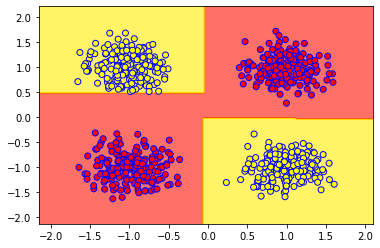

In [9]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X, y)

plot_decision_boundaries(clf, X, y)

scikit-learn also provides some nice helper functions to visualize Decision Trees. 

One of those functions is `sklearn.tree.export_text` which returns a string representation of the decisions. 

**TASK: Have a look at the print-out of the decision tree below and the plot of it decisions on our `X` and `y` above.**

In [10]:
from sklearn.tree import export_text

print(export_text(clf, decimals=3))

|--- feature_0 <= 1.124
|   |--- feature_1 <= 0.479
|   |   |--- feature_0 <= -0.063
|   |   |   |--- class: 0
|   |   |--- feature_0 >  -0.063
|   |   |   |--- feature_1 <= -0.032
|   |   |   |   |--- class: 1
|   |   |   |--- feature_1 >  -0.032
|   |   |   |   |--- class: 0
|   |--- feature_1 >  0.479
|   |   |--- feature_0 <= -0.055
|   |   |   |--- class: 1
|   |   |--- feature_0 >  -0.055
|   |   |   |--- class: 0
|--- feature_0 >  1.124
|   |--- feature_1 <= -0.046
|   |   |--- class: 1
|   |--- feature_1 >  -0.046
|   |   |--- class: 0



It also provides `export_graphviz` which will create a nice graph representation of the classifier in the popular *graphviz* *dot* format.

In [11]:
# Helper function that renders a graphviz graph in the IPython notebook
# You don't need to read / understand this

from sklearn.tree import export_graphviz

def visualize_sklearn_tree(tree: DecisionTreeClassifier):
  dot_data = io.StringIO()
  export_graphviz(
      decision_tree=tree,
      out_file=dot_data,
  )
  graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
  return Image(graph.create_png())

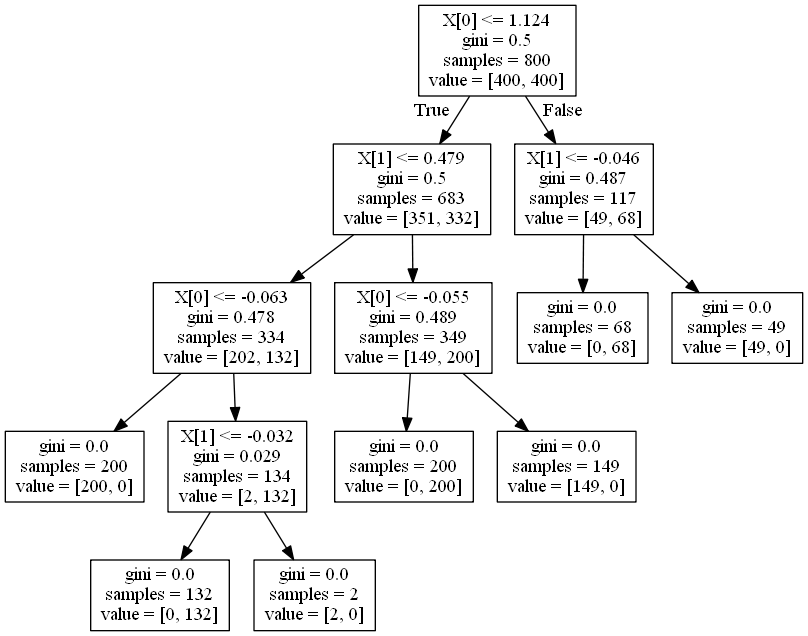

In [12]:
visualize_sklearn_tree(clf)

Now that we know how to visualize decision trees, we are ready to explore how they work on the data.  

### Task 2a. Split Orientation

One quirk of many implementations of Decision Trees is that the decision boundaries are always parallel to the data axes, meaning that you will never see a diagonal line as a boundary between red and yellow in our case. They will always be horizontal or vertical. 

**TASK: Reflect on why this is the case.**

To get more intuition you can study the next cell and its output. Change the value of the variable `angle` (in radians) to rotate our synthetic data and see the influence on the decision boundaries.

Angle with max number of decision boundaries: 1.3914017602250057
Number of decision boundaries at this angle: 18


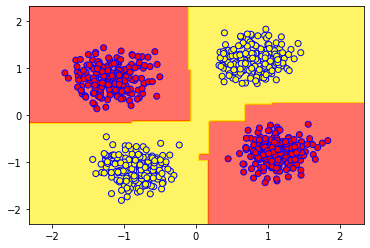

In [20]:


#angle = 20  # to be changed
angle_leaves_dict = {}
for angle in np.linspace(-np.pi, np.pi, 360):
    rot = np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)],
    ])
    X_rot = X @ rot

    clf2 = DecisionTreeClassifier()
    clf2.fit(X_rot, y)

    angle_leaves_dict[angle] = clf2.get_n_leaves()

max_value = max(zip(angle_leaves_dict.values(), angle_leaves_dict.keys()))
print("Angle with max number of decision boundaries: " + str(max_value[1]))
print("Number of decision boundaries at this angle: " + str(max_value[0]))

angle = max_value[1]
rot = np.array([
    [np.cos(angle), -np.sin(angle)],
    [np.sin(angle), np.cos(angle)],
])
X_rot = X @ rot

clf2 = DecisionTreeClassifier()
clf2.fit(X_rot, y)
plot_decision_boundaries(clf2, X_rot, y)

**TASK: Find an angle that enforces a decision tree with as many decision boundaries as possible**

For this you can either plot the data and count horizontal/vertical lines, or use function `clf2.get_n_leaves()`. 

## 📢 **HAND-IN** 📢: Enter the following in **Moodle**

* "Worst" angle and corresponding number of decision boundaries 

# Task 3: Random Forests (5 Points)

A Random Forest is a collection of Decision Trees. One reason to combine multiple Decision Trees into a Random Forest is to counteract the tendency of Decision Trees to overfit the data.

First, we generate some synthetic data. You can see that this data set has $4$ classes that mix together a lot in the middle (around the origin).

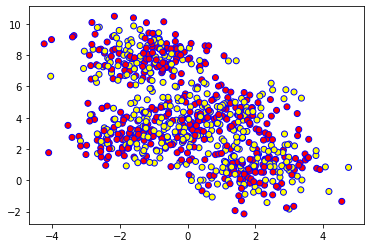

In [14]:
# we are using "_RF" for the variable names to not confuse/mix it with the data from the previous tasks

X_RF, y_RF = make_blobs(
    n_samples=800,
    n_features=2,
    random_state=0,
    centers=4,
    cluster_std=1.,
)

plt.scatter(X_RF[:, 0], X_RF[:, 1], c=y, cmap='autumn', edgecolors='b')

In the cell below, we train a single Decision Tree on this data. You should be able to see some odd artefacts in the decision regions. For example in the upper half of the plot there is a stripe of red going far into yellow territory.

This is an indicator, that this tree has overfitted this data.

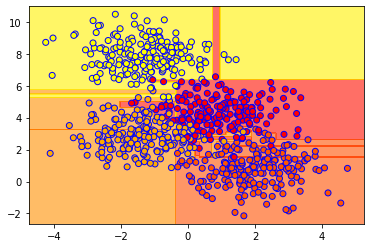

In [15]:
clf = DecisionTreeClassifier()
clf.fit(X_RF, y_RF)
plot_decision_boundaries(clf, X_RF, y_RF)

### Task 3a. Random Forest Implementation

In the next cell we provide one possible implementation of a Random Forest.

To train a Random Forest, we train a collection of Decision Trees. Each tree is only trained on a subset (sampled with replacement) of the full training data. This is called **bootstrapping**.

To get a prediction from a Random Forest, we compute the majority vote of all its constituent Decision Trees.

Read and try to understand the code in the next cell.

In [18]:
from sklearn.model_selection import train_test_split


class RandomForest:

  def __init__(
    self,
    n_trees: int,
    train_fraction_per_tree: float,
  ):
    # the number of trees in this forest
    self.n_trees = n_trees

    # each tree will only be trained on a subset of the full data set
    self.train_fraction_per_tree = train_fraction_per_tree

    # attribute to store the trees of this forest
    self.trees: Optional[List[DecisionTreeClassifier]] = None

  def fit(self, X, y):
    trees = []
    for tree_ix in range(self.n_trees):

      # we (ab-)use the train_test_split function to bootstrap sample the training
      # data for each tree of the forest
      # Note that we give a different random seed for each tree, otherwise they
      # would all be trained on identical subsets
      # We also use stratification so the class proportions are preserved
      x_train, _, y_train, _ = train_test_split(
          X, y,
          train_size=self.train_fraction_per_tree,
          random_state=RANDOM_SEED + tree_ix,
          shuffle=True,
          stratify=y,
      )

      tree = DecisionTreeClassifier().fit(x_train, y_train)
      trees.append(tree)

    self.trees = trees
    return self

  def predict(self, X):
    if self.trees is None:
      raise ValueError(f"you have to call `fit` before you can get predictions")

    n_samples = X.shape[0]

    # collect predictions of all trees, this will result in an numpy array
    # with shape [n_samples, n_trees]
    preds = np.array([
        tree.predict(X)
        for tree in self.trees
    ]).T

    # for efficiency pre-initialize result array
    result = np.zeros(n_samples, dtype=int)

    for s_ix in range(n_samples):
      # compute majority vote for each sample
      result[s_ix] = np.bincount(preds[s_ix, :]).argmax()
    
    return result


Below we apply our Random Forest to `X` and `y`. You'll notice that there are still the same signs of overfitting.

**TASK: Modify the `n_trees` and `train_fraction_per_tree` parameters until the red stripe in the yellow territory disappears.**


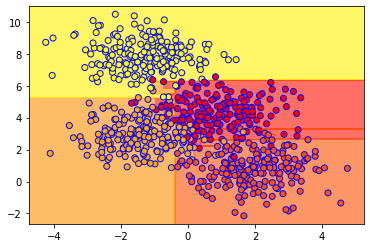

In [32]:
forest = RandomForest(n_trees=5, train_fraction_per_tree=0.4)
forest.fit(X_RF, y_RF)

plot_decision_boundaries(forest, X_RF, y_RF)

## 📢 **HAND-IN** 📢: Enter the following in **Moodle**

* the values you used for `n_trees` and `train_fraction_per_tree`
* the plot of the resulting decision boundaries (output of `plot_decision_boundaries`)